# Experiments

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.init as init
from torchvision import transforms, datasets
import seaborn as sns
from ipywidgets import interact
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')



## Function definitions 

In [5]:
_global_data_dir = '.'

def orthogonality_gap(H):
    H = H.flatten(start_dim=1)
    N = H.shape[0]
    D = H.shape[1]
    C = torch.matmul(H,H.transpose(0,1)) 
    C = C / torch.trace(C)
    gap = torch.norm(C - torch.eye(N).to(C.device)/N, p='fro')
    return gap
    

class ConvNet2D(torch.nn.Module):
    def __init__(self, in_features, stride, norm_method, in_channels, hidden_channels, 
                 num_hidden_layers, out_features, kernel_size, init_method, 
                 nonlinearity, bias=False, padding_mode = 'reflect'):
        super(ConvNet2D, self).__init__()
        normalizations = { 
            'batchnorm': nn.BatchNorm2d,
            'vanilla': nn.Identity,
        }
        padding = int(kernel_size / 2)

        weight_init = initializations[init_method]
        act = activations[nonlinearity]
        norm = normalizations[norm_method]
        channels = [in_channels] 
        ftrs = [in_features[0]]
        for l in range(num_hidden_layers):
            ftrs.append(int(np.ceil(ftrs[-1]/stride)))
            if l == 0:
                channels.append(hidden_channels)
            else:
                channels.append(int(channels[-1]*stride))   
            
        layers = []
        for l in range(num_hidden_layers):
            conv2d = nn.Conv2d(channels[l],channels[l+1], kernel_size, stride=stride,
                            padding=padding, padding_mode=padding_mode, bias=bias)
            weight_init(conv2d.weight, gain=init.calculate_gain('conv2d'))
            layers.append(nn.Sequential( act(), conv2d, norm(channels[l+1]) ))

        readout = nn.Linear(ftrs[-1] *ftrs[-1] * channels[-1], out_features)
        weight_init(readout.weight, gain=init.calculate_gain('linear'))
        self.readout = readout 
        self.layers = layers
        self.seq = nn.Sequential(*layers)

    def calc_gap(self, batches):
        V = []
        for x in batches:
            H = x  
            gap = []
            for i,l in enumerate(self.layers):
                gap.append(orthogonality_gap(H).cpu().data)
                H = l(H)
            gap = np.array(gap)
            V.append(gap)
        return np.array(V)     

    def forward(self, x):
        return self.readout(self.seq(x).flatten(start_dim=1))  
    

class MLP(torch.nn.Module):
    def __init__(self, D_in, D, L, init_method, norm_method, nonlinearity):
        super(MLP, self).__init__()

        normalizations = { 
            'batchnorm': nn.BatchNorm1d,
            'vanilla': nn.Identity,
        }
        
        weight_init = initializations[init_method]
        act = activations[nonlinearity]
        norm = normalizations[norm_method]
        widths = [D_in] + [D] * L
        layers = []
        for l in range(L):
            lin = nn.Linear(widths[l],widths[l+1], bias=False)
            weight_init(lin.weight, gain=init.calculate_gain(nonlinearity))
            layers.append(nn.Sequential( act(), lin, norm(widths[l+1]) ))
        self.layers = layers
        self.seq = nn.Sequential(*layers)
        
    def forward(self, x):
        self.seq(x)

    def calc_gap(self, batches):
        V = []
        for x in batches:
            H = x  
            gap = [] 
            for l in self.layers:
                gap.append(orthogonality_gap(H).cpu().data)
                H = l(H)
            gap = np.array(gap)
            V.append(gap)
            
        return np.array(V)


activations = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh,
    'linear': nn.Identity,
}

initializations = {
    'xavier_uniform' : init.xavier_uniform_,
    'xavier_normal' : init.xavier_normal_,
    'kaiming_normal': init.kaiming_normal_,
    'kaiming_uniform': init.kaiming_uniform_,
}
         

def get_batches(N,D, source, num_batches, gap, batch_size):
    transf = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))])
    batches = []
    if source == 'MNIST':
        D_in, in_channels = 28*28, 1
        dataset = datasets.MNIST(_global_data_dir, download=True,train=True, transform=transf)
        train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        it = iter(train_loader)
        batches = [next(it)[0] for i in range(num_batches)]
    elif source == 'CIFAR10':
        dataset = datasets.CIFAR10(_global_data_dir, download=True, train=True, transform=transf)
        train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
        it = iter(train_loader)
        batches = [next(it)[0] for i in range(num_batches)]
    elif source=='random':
        for i in range(num_batches):
            H = torch.randn((N,D))
            batches.append(H)
        # enforce input orthonormality gap 
        for i, H in enumerate(batches):
            C = torch.eye(D) * (1/D - gap/(D-1))
            r = np.random.randint(D)
            C[r,r] = (1/D+gap)
            H = torch.matmul(H, C)
            batches[i] = H.reshape(N,1,1,D)
    elif source=='random2D':
        D2 = D * D
        for i in range(num_batches):
            H = torch.randn((N,D2))
            batches.append(H)
        # enforce input orthonormality gap 
        for i, H in enumerate(batches):
            C = torch.eye(D2) * (1/D2 - gap/(D2-1))
            r = np.random.randint(D2)
            C[r,r] = (1/D2+gap)
            H = torch.matmul(H, C)
            batches[i] = H.reshape(N, 1, D, D)

    batches = torch.stack(batches)
    return batches

   

In [6]:
def default_mlp(batch_size=8, 
                hidden_width=100, 
                num_repeat=50, 
                input_orthogonality_gap=.5, 
                num_hidden_layers=30,
                nonlinearity='relu',  norm_method='batchnorm', 
                init_method='xavier_normal', 
                data_source='CIFAR10'):
    batches = get_batches(N=batch_size, 
           batch_size=batch_size,
           source=data_source, 
           D=hidden_width, 
           num_batches=num_repeat, 
           gap=input_orthogonality_gap)
    batches = batches.flatten(start_dim=2)
    mlp = MLP(D_in = batches.shape[2], D=hidden_width, L=num_hidden_layers, init_method=init_method, 
                  norm_method=norm_method, nonlinearity=nonlinearity)
    V = mlp.calc_gap(batches)
    return V
    
    
    
def default_convnet(
    stride=1, 
    in_features = 28,
    batch_size = 8,
    num_repeat = 50,      
    out_features = 10,
    hidden_channels = 100,
    kernel_size = 3,
    num_hidden_layers = 30,
    input_orthogonality_gap = 0.3,
    padding_mode = 'zero',
    nonlinearity = 'relu',
    norm_method = 'batchnorm',
    init_method = 'xavier_normal',
    data_source = 'CIFAR10',):
    batches = get_batches(N=batch_size, 
            batch_size=batch_size,
            source=data_source, 
            D=in_features, 
            num_batches=num_repeat, 
            gap=input_orthogonality_gap)

    in_channels = batches[0].shape[1]
    in_features = (batches[0].shape[2], batches[0].shape[3])
    net = ConvNet2D(in_features=in_features, 
                    stride=stride,
                    init_method = init_method,
                    nonlinearity=nonlinearity,
                    num_hidden_layers=num_hidden_layers,
                    in_channels=in_channels, 
                    norm_method=norm_method,
                    hidden_channels=hidden_channels, 
                    out_features=out_features,
                    kernel_size=kernel_size) 
    V = net.calc_gap(batches)
    return V

## Figures for the paper 


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


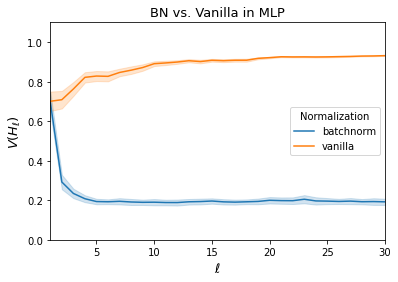

In [7]:
def paper_fig6a():
    V = dict()
    for norm_method in ['batchnorm', 'vanilla']:
        vals = default_mlp(norm_method=norm_method, )
        V.update( {(norm_method, i+1, l+1):[v] for i, batch in enumerate(vals) for l,v in enumerate(batch)} )
    df = pd.DataFrame(V).transpose().reset_index()
    df = pd.DataFrame(df.values, columns=['Normalization','batch','layer','gap'])

    plt.figure()
    df.layer = df.layer.astype(np.float32)
    df.gap = df.gap.astype(np.float32)
    g = sns.lineplot(df.layer, df.gap, hue=df.Normalization, ci='sd')
    g.set(ylim=(0,1.1),xlim=(1,30))
    g.set_xlabel("$\ell$",fontsize=13)
    g.set_ylabel("$V(H_\ell)$",fontsize=13)
    g.set_title("BN vs. Vanilla in MLP", fontsize=13)
    plt.savefig('Fig6A.pdf');
    
paper_fig6a();


    

In [ ]:
def paper_fig6b():
    V = dict()
    for norm_method in ['batchnorm', 'vanilla']:
        vals = default_convnet(norm_method=norm_method)
        V.update( {(norm_method, i+1, l+1):[v] for i, batch in enumerate(vals) for l,v in enumerate(batch)} )

    df = pd.DataFrame(V).transpose().reset_index()
    df = pd.DataFrame(df.values, columns=['Normalization','batch','layer','gap'])

    plt.figure()
    df.layer = df.layer.astype(np.float32)
    df.gap = df.gap.astype(np.float32)
    g = sns.lineplot(df.layer, df.gap, hue=df.Normalization, ci='sd')
    g.set(ylim=(0,1.1),xlim=(1,30));
    g.set_xlabel("$\ell$",fontsize=13)
    g.set_ylabel("$V(H_\ell)$",fontsize=13)
    g.set_title("BN vs. Vanilla in MLP", fontsize=13)
    g.set(title="BN vs. Vanilla in ConvNet")
    plt.savefig('Fig6B.pdf');    
paper_fig6b();


Files already downloaded and verified
